# Imports

In [1]:
# standard imports
import numpy as np
import os
import sys
import csv
import random
from collections import Counter
import pandas as pd
from datetime import datetime
from importlib import reload


# torch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms


# other imports
from tqdm.notebook import tqdm

# custom library imports
from library import plotting as pl
from library import earlyStopping as es
from library import getdata as gd
from library import elbo 
from library import att_LSTM_vae as att



# Environment

In [2]:
%load_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,pandas

Author: Nicole Königstein
2022-05-15 

CPython 3.9.12
IPython 7.19.0

compiler   : Clang 13.1.6 (clang-1316.0.21.2)
system     : Darwin
release    : 21.1.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.9.12
IPython 7.19.0

numpy 1.19.5
pandas 1.2.3


# Helper functions

## Plotting

In [3]:
def results_plot(net, dataset, L=512, alpha=0.01, ELBO_loss=None):
    """
    This function plots the probability of the VAE from the following paper:
    https://www.joao-pereira.pt/publications/accepted_version_ICMLA18.pdf
    :param net: the neural network 
    :param dataset: the dataset to test the anomaly on e.g. test1
    :param L: the number for the Monte Carlo Method as an int
    :param alpha: the Log threshold
    :param ELBO_loss: the loss criterion for the network

    """
    # get all the simularity scores
    all_sim_scores = att.get_sim_scores(net, dataset, L=L, ELBO_loss=ELBO_loss)
    probs = all_sim_scores.flatten()  # flatten the tensor
    # get the anomaly index
    idx_anomaly = probs < np.log(alpha)
    x = np.arange(len(dataset.data))

    # init the plots
    fig, ax = plt.subplots(2, 1,
                           gridspec_kw=dict(
                               width_ratios=[1], height_ratios=[5, 1]),
                           figsize=(20, 5))
    fig.subplots_adjust(hspace=0, wspace=0.05)

    # normal data
    ax[0].plot(x, dataset.data, 'darkorange', label='Normal data')
    ax[0].set_xlim(np.min(x), np.max(x))

    # grey area to indiate the anomaly idx in the plot
    trans = mtransforms.blended_transform_factory(
        ax[0].transData, ax[0].transAxes)
    ax[0].fill_between(x, np.min(dataset.data), np.max(
        dataset.data), where=idx_anomaly, facecolor='lightgrey', alpha=0.5, transform=trans)

    # Get min and max similarity score
    min_sim = np.quantile(all_sim_scores, 0.02)
    max_sim = np.quantile(all_sim_scores, 0.9)

    # plot the e reconstruction probabiliy as an image
    ax[1].imshow(all_sim_scores.reshape(1, -1), aspect='auto',
                 cmap='RdYlGn', interpolation='spline16', vmin=min_sim, vmax=max_sim)
    ax[1].grid(False)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

## Training Functions

In [4]:
def train(dataset, net, optimizer, criterion, batch_size, lamba_kl=0.01, num_workers=0, scheduler=None, scheduler_stop_step=np.inf):

    # Set network into training mode
    net.batch_size = batch_size
    net.init_hidden()
    net.train()

    # load the dataset
    loader = DataLoader(dataset=dataset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

    iter_ = 0
    for x, label in loader:

        # Cast to gpu if available
        if torch.cuda.is_available():
            x = x.to(torch.device(0))

        # Change batch size in last iteration
        if not x.shape[0] == batch_size:
            net.batch_size = x.shape[0]
            net.init_hidden()

        # Zero gradients
        optimizer.zero_grad()
        # Make forward pass with model
        outputs = net(x)
        # Calculate loss and backprop
        loss = criterion(x, outputs, 0.01, lamba_kl)
        loss.backward()
        optimizer.step()

        if scheduler and iter_ < scheduler_stop_step:
            scheduler.step()

        iter_ += 1

    # Revert to correct net batch size
    net.batch_size = batch_size
    net.init_hidden()

    return net


def validate(dataset, net, criterion, batch_size, lambda_kl=0.01):

    # Set network into evalution mode
    net.batch_size = batch_size
    net.init_hidden()
    net.eval()

    loader = DataLoader(dataset=dataset, batch_size=batch_size)

    total_loss = 0

    for x, label in loader:

        # Cast to gpu if available
        if torch.cuda.is_available():
            x = x.to(torch.device(0))

        # Change batch size in last iteration
        if not x.shape[0] == batch_size:
            net.batch_size = x.shape[0]
            net.init_hidden()

        # Make forward pass with model
        outputs = net(x)
        loss = criterion(x, outputs, 0.01, lambda_kl)
        total_loss += loss.item()

    # Set model to train mode and revert batch size
    net.batch_size = batch_size
    net.init_hidden()
    net.train()

    return total_loss/len(loader)


def train_validate(train_dataset, val_dataset, net, optimizer, criterion, n_epochs, batch_size,
                   num_workers=0, verbose=True,
                   scheduler=None, scheduler_stop_step=np.inf, patience=3, verbose_es=False, delta=3e-5):

    # initialize the early_stopping object
    early_stopping = es.EarlyStopping(
        patience=patience, verbose_es=verbose_es, delta=delta)

    train_losses = []
    val_losses = []
    lambda_kl = 0
    inc_val = 2/n_epochs

    for e in range(n_epochs):

        # Train model
        net = train(train_dataset, net, optimizer, criterion, batch_size,
                    lambda_kl, num_workers, scheduler, scheduler_stop_step)

        # Evaluate model on training data again and validate
        with torch.no_grad():
            train_loss = validate(train_dataset, net,
                                  criterion, batch_size, lambda_kl)
            val_loss = validate(val_dataset, net, criterion,
                                batch_size, lambda_kl)

            # early_stopping needs the validation loss to check if it has decresed,
            # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        if verbose:
            print(
                "Epoch {0}/{1} \tTrain loss = {2:.3f}\tVal loss = {3:.3f}".format(
                    e+1, n_epochs, train_loss, val_loss)
            )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        lambda_kl += inc_val

    return net, (train_losses, val_losses)

# Model training

In [5]:
# Set seed mu
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

T_w = 96  # Window length for the time series
batch_size = 100

# just change here the file path to access the other data for
# all data used in the notebook for training, testing & plotting
filepath = "data"

# choose a subset for the GetData Class to access train/val/test data
# smooth_window is used to smooth the time series with a moving average
train_data = gd.GetData(T_w, filepath, subset='train', smooth_window=0)
val_data = gd.GetData(T_w, filepath, subset='val', smooth_window=0)
model_path = "models"


# Model hyperparameters
n_epochs = 2500
z_dim = 3
h_dim = 128  # Number of LSTM units in each direction
x_dim = 1  # univariate (1) or multivariate (> 1)
lr = 0.001

# to easily change between the two distributions
normal = torch.distributions.normal.Normal
laplace = torch.distributions.laplace.Laplace

# change the ELBO Loss distribution
criterion = elbo.ELBO_distribution(pdf_distribution=normal)
parameters = [z_dim, T_w, x_dim, h_dim, model_path, batch_size]
net = att.AttLSTMVAE(*parameters)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True)

# scheduler for Learning Rate Decay
# gamma -> Multiplicative factor of learning rate decay
scheduler = StepLR(optimizer, step_size=350, gamma=0.6)

# set patience for the early stopping
patience = 10

# Train model
if torch.cuda.is_available():
    net = net.to(torch.device(0))

pars = {'train_dataset': train_data,
        'val_dataset': val_data,
        'net': net,
        'optimizer': optimizer,
        'criterion': criterion,
        'n_epochs': n_epochs,
        'batch_size': batch_size,
        'num_workers': 0,
        'verbose': True,
        'scheduler': scheduler,
        'patience': patience,
        'verbose_es': False,
        'delta': 0}

net, (train_losses, val_losses) = train_validate(**pars)

Epoch 1/2500 	Train loss = 0.633	Val loss = 0.633
Epoch 2/2500 	Train loss = 0.619	Val loss = 0.613
Epoch 3/2500 	Train loss = 0.596	Val loss = 0.602
Epoch 4/2500 	Train loss = 0.555	Val loss = 0.562
Epoch 5/2500 	Train loss = 0.519	Val loss = 0.517
Epoch 6/2500 	Train loss = 0.517	Val loss = 0.507
Epoch 7/2500 	Train loss = 0.508	Val loss = 0.447
Epoch 8/2500 	Train loss = 0.428	Val loss = 0.441
Epoch 9/2500 	Train loss = 0.418	Val loss = 0.419
Epoch 10/2500 	Train loss = 0.399	Val loss = 0.379
Epoch 11/2500 	Train loss = 0.341	Val loss = 0.362
Epoch 12/2500 	Train loss = 0.325	Val loss = 0.300
Epoch 13/2500 	Train loss = 0.286	Val loss = 0.270
Epoch 14/2500 	Train loss = 0.230	Val loss = 0.232
Epoch 15/2500 	Train loss = 0.189	Val loss = 0.197
Epoch 16/2500 	Train loss = 0.192	Val loss = 0.182
Epoch 17/2500 	Train loss = 0.213	Val loss = 0.216
Epoch 18/2500 	Train loss = 0.177	Val loss = 0.227
Epoch 19/2500 	Train loss = 0.204	Val loss = 0.167
Epoch 20/2500 	Train loss = 0.161	Val lo

Epoch 160/2500 	Train loss = 0.176	Val loss = 0.180
Epoch 161/2500 	Train loss = 0.177	Val loss = 0.181
Epoch 162/2500 	Train loss = 0.168	Val loss = 0.203
Epoch 163/2500 	Train loss = 0.172	Val loss = 0.174
Epoch 164/2500 	Train loss = 0.173	Val loss = 0.186
Epoch 165/2500 	Train loss = 0.184	Val loss = 0.177
Epoch 166/2500 	Train loss = 0.156	Val loss = 0.175
Epoch 167/2500 	Train loss = 0.168	Val loss = 0.161
Epoch 168/2500 	Train loss = 0.171	Val loss = 0.159
Epoch 169/2500 	Train loss = 0.141	Val loss = 0.170
Epoch 170/2500 	Train loss = 0.142	Val loss = 0.154
Epoch 171/2500 	Train loss = 0.131	Val loss = 0.116
Epoch 172/2500 	Train loss = 0.125	Val loss = 0.164
Epoch 173/2500 	Train loss = 0.126	Val loss = 0.123
Epoch 174/2500 	Train loss = 0.104	Val loss = 0.091
Epoch 175/2500 	Train loss = 0.102	Val loss = 0.112
Epoch 176/2500 	Train loss = 0.089	Val loss = 0.121
Epoch 177/2500 	Train loss = 0.116	Val loss = 0.118
Epoch 178/2500 	Train loss = 0.096	Val loss = 0.100
Epoch 179/25

Epoch 314/2500 	Train loss = -1.333	Val loss = -1.375
Epoch 315/2500 	Train loss = -1.107	Val loss = -1.155
Epoch 316/2500 	Train loss = -1.194	Val loss = -1.180
Epoch 317/2500 	Train loss = -1.234	Val loss = -1.163
Epoch 318/2500 	Train loss = -0.839	Val loss = -1.006
Epoch 319/2500 	Train loss = -1.143	Val loss = -1.215
Epoch 320/2500 	Train loss = -0.805	Val loss = -0.605
Epoch 321/2500 	Train loss = -1.330	Val loss = -1.333
Epoch 322/2500 	Train loss = -1.351	Val loss = -1.333
Epoch 323/2500 	Train loss = -0.921	Val loss = -1.067
Epoch 324/2500 	Train loss = -1.415	Val loss = -1.354
Epoch 325/2500 	Train loss = -1.211	Val loss = -1.138
Epoch 326/2500 	Train loss = -0.890	Val loss = -1.145
Epoch 327/2500 	Train loss = -1.341	Val loss = -1.193
Epoch 328/2500 	Train loss = -1.362	Val loss = -1.292
Epoch 329/2500 	Train loss = -1.287	Val loss = -1.034
Epoch 330/2500 	Train loss = -1.335	Val loss = -1.350
Epoch 331/2500 	Train loss = -1.386	Val loss = -1.418
Epoch 332/2500 	Train loss =

Epoch 466/2500 	Train loss = -1.405	Val loss = -1.485
Epoch 467/2500 	Train loss = -1.483	Val loss = -1.485
Epoch 468/2500 	Train loss = -1.507	Val loss = -1.504
Epoch 469/2500 	Train loss = -1.538	Val loss = -1.535
Epoch 470/2500 	Train loss = -1.511	Val loss = -1.538
Epoch 471/2500 	Train loss = -1.584	Val loss = -1.533
Epoch 472/2500 	Train loss = -1.607	Val loss = -1.577
Epoch 473/2500 	Train loss = -1.558	Val loss = -1.550
Epoch 474/2500 	Train loss = -1.628	Val loss = -1.641
Epoch 475/2500 	Train loss = -1.649	Val loss = -1.643
Epoch 476/2500 	Train loss = -1.633	Val loss = -1.646
Epoch 477/2500 	Train loss = -1.689	Val loss = -1.648
Epoch 478/2500 	Train loss = -1.652	Val loss = -1.725
Epoch 479/2500 	Train loss = -1.720	Val loss = -1.745
Epoch 480/2500 	Train loss = -1.743	Val loss = -1.753
Epoch 481/2500 	Train loss = -1.695	Val loss = -1.793
Epoch 482/2500 	Train loss = -1.790	Val loss = -1.792
Epoch 483/2500 	Train loss = -1.766	Val loss = -1.793
Epoch 484/2500 	Train loss =

Epoch 619/2500 	Train loss = -1.782	Val loss = -1.775
Epoch 620/2500 	Train loss = -1.840	Val loss = -1.830
Epoch 621/2500 	Train loss = -1.828	Val loss = -1.857
Epoch 622/2500 	Train loss = -1.859	Val loss = -1.840
Epoch 623/2500 	Train loss = -1.879	Val loss = -1.882
Epoch 624/2500 	Train loss = -1.881	Val loss = -1.901
Epoch 625/2500 	Train loss = -1.894	Val loss = -1.911
Epoch 626/2500 	Train loss = -1.910	Val loss = -1.913
Epoch 627/2500 	Train loss = -1.917	Val loss = -1.880
Epoch 628/2500 	Train loss = -1.960	Val loss = -1.969
Epoch 629/2500 	Train loss = -1.935	Val loss = -1.931
Epoch 630/2500 	Train loss = -1.950	Val loss = -1.985
Epoch 631/2500 	Train loss = -2.010	Val loss = -1.950
Epoch 632/2500 	Train loss = -2.014	Val loss = -2.035
Epoch 633/2500 	Train loss = -2.027	Val loss = -2.041
Epoch 634/2500 	Train loss = -2.026	Val loss = -2.052
Epoch 635/2500 	Train loss = -2.035	Val loss = -1.977
Epoch 636/2500 	Train loss = -2.090	Val loss = -2.107
Epoch 637/2500 	Train loss =

Epoch 771/2500 	Train loss = -2.650	Val loss = -2.378
Epoch 772/2500 	Train loss = -3.176	Val loss = -3.254
Epoch 773/2500 	Train loss = -2.713	Val loss = -2.964
Epoch 774/2500 	Train loss = -3.343	Val loss = -3.326
Epoch 775/2500 	Train loss = -2.256	Val loss = -2.120
Epoch 776/2500 	Train loss = -3.343	Val loss = -3.352
Epoch 777/2500 	Train loss = -3.130	Val loss = -3.058
Epoch 778/2500 	Train loss = -3.402	Val loss = -3.235
Epoch 779/2500 	Train loss = -3.011	Val loss = -3.091
Epoch 780/2500 	Train loss = -3.400	Val loss = -3.368
Epoch 781/2500 	Train loss = -2.407	Val loss = -2.526
Epoch 782/2500 	Train loss = -3.190	Val loss = -3.352
Epoch 783/2500 	Train loss = -2.473	Val loss = -2.074
Epoch 784/2500 	Train loss = -3.401	Val loss = -3.375
Epoch 785/2500 	Train loss = -2.388	Val loss = -2.599
Epoch 786/2500 	Train loss = -3.387	Val loss = -3.398
Epoch 787/2500 	Train loss = -2.715	Val loss = -2.605
Epoch 788/2500 	Train loss = -3.354	Val loss = -3.371
Epoch 789/2500 	Train loss =

Epoch 923/2500 	Train loss = -2.949	Val loss = -2.871
Epoch 924/2500 	Train loss = -2.926	Val loss = -3.144
Epoch 925/2500 	Train loss = -3.397	Val loss = -3.434
Epoch 926/2500 	Train loss = -3.201	Val loss = -3.346
Epoch 927/2500 	Train loss = -3.432	Val loss = -3.395
Epoch 928/2500 	Train loss = -3.283	Val loss = -3.246
Epoch 929/2500 	Train loss = -3.260	Val loss = -3.136
Epoch 930/2500 	Train loss = -3.045	Val loss = -3.077
Epoch 931/2500 	Train loss = -3.308	Val loss = -3.401
Epoch 932/2500 	Train loss = -3.222	Val loss = -3.149
Epoch 933/2500 	Train loss = -3.374	Val loss = -3.321
Epoch 934/2500 	Train loss = -3.262	Val loss = -3.268
Epoch 935/2500 	Train loss = -3.443	Val loss = -3.352
Epoch 936/2500 	Train loss = -3.101	Val loss = -3.232
Epoch 937/2500 	Train loss = -3.557	Val loss = -3.579
Epoch 938/2500 	Train loss = -3.397	Val loss = -3.478
Epoch 939/2500 	Train loss = -3.539	Val loss = -3.554
Epoch 940/2500 	Train loss = -3.450	Val loss = -3.291
Epoch 941/2500 	Train loss =

Epoch 1074/2500 	Train loss = -3.796	Val loss = -3.763
Epoch 1075/2500 	Train loss = -3.863	Val loss = -3.861
Epoch 1076/2500 	Train loss = -3.815	Val loss = -3.845
Epoch 1077/2500 	Train loss = -3.853	Val loss = -3.780
Epoch 1078/2500 	Train loss = -3.711	Val loss = -3.711
Epoch 1079/2500 	Train loss = -3.777	Val loss = -3.840
Epoch 1080/2500 	Train loss = -3.638	Val loss = -3.639
Epoch 1081/2500 	Train loss = -3.906	Val loss = -3.811
Epoch 1082/2500 	Train loss = -3.507	Val loss = -3.727
Epoch 1083/2500 	Train loss = -3.832	Val loss = -3.918
Epoch 1084/2500 	Train loss = -3.741	Val loss = -3.638
Epoch 1085/2500 	Train loss = -3.940	Val loss = -3.806
Epoch 1086/2500 	Train loss = -3.793	Val loss = -3.708
Epoch 1087/2500 	Train loss = -3.938	Val loss = -3.962
Epoch 1088/2500 	Train loss = -3.883	Val loss = -3.942
Epoch 1089/2500 	Train loss = -3.815	Val loss = -3.866
Epoch 1090/2500 	Train loss = -3.898	Val loss = -3.837
Epoch 1091/2500 	Train loss = -3.922	Val loss = -3.972
Epoch 1092

Epoch 1224/2500 	Train loss = -3.495	Val loss = -3.305
Epoch 1225/2500 	Train loss = -3.481	Val loss = -3.464
Epoch 1226/2500 	Train loss = -3.068	Val loss = -3.446
Epoch 1227/2500 	Train loss = -3.081	Val loss = -3.174
Epoch 1228/2500 	Train loss = -3.405	Val loss = -2.969
Epoch 1229/2500 	Train loss = -3.492	Val loss = -3.587
Epoch 1230/2500 	Train loss = -2.809	Val loss = -3.133
Epoch 1231/2500 	Train loss = -3.042	Val loss = -3.050
Epoch 1232/2500 	Train loss = -3.597	Val loss = -3.487
Epoch 1233/2500 	Train loss = -3.564	Val loss = -3.488
Epoch 1234/2500 	Train loss = -2.652	Val loss = -3.018
Epoch 1235/2500 	Train loss = -2.872	Val loss = -2.842
Epoch 1236/2500 	Train loss = -3.399	Val loss = -3.613
Epoch 1237/2500 	Train loss = -3.473	Val loss = -3.471
Epoch 1238/2500 	Train loss = -3.203	Val loss = -3.098
Epoch 1239/2500 	Train loss = -3.292	Val loss = -3.106
Epoch 1240/2500 	Train loss = -3.573	Val loss = -3.594
Epoch 1241/2500 	Train loss = -3.556	Val loss = -3.441
Epoch 1242

Epoch 1374/2500 	Train loss = -4.028	Val loss = -4.029
Epoch 1375/2500 	Train loss = -4.157	Val loss = -4.220
Epoch 1376/2500 	Train loss = -4.152	Val loss = -4.236
Epoch 1377/2500 	Train loss = -4.222	Val loss = -4.241
Epoch 1378/2500 	Train loss = -4.231	Val loss = -4.080
Epoch 1379/2500 	Train loss = -3.975	Val loss = -4.125
Epoch 1380/2500 	Train loss = -4.199	Val loss = -4.199
Epoch 1381/2500 	Train loss = -3.983	Val loss = -4.070
Epoch 1382/2500 	Train loss = -4.151	Val loss = -4.215
Epoch 1383/2500 	Train loss = -3.822	Val loss = -3.916
Epoch 1384/2500 	Train loss = -4.177	Val loss = -4.275
Epoch 1385/2500 	Train loss = -4.070	Val loss = -4.139
Epoch 1386/2500 	Train loss = -4.177	Val loss = -4.144
Epoch 1387/2500 	Train loss = -4.144	Val loss = -4.078
Epoch 1388/2500 	Train loss = -4.014	Val loss = -3.976
Epoch 1389/2500 	Train loss = -3.875	Val loss = -3.922
Epoch 1390/2500 	Train loss = -3.686	Val loss = -3.919
Epoch 1391/2500 	Train loss = -4.096	Val loss = -3.910
Epoch 1392

Epoch 1524/2500 	Train loss = -4.277	Val loss = -4.158
Epoch 1525/2500 	Train loss = -4.166	Val loss = -4.199
Epoch 1526/2500 	Train loss = -4.287	Val loss = -4.334
Epoch 1527/2500 	Train loss = -4.053	Val loss = -4.285
Epoch 1528/2500 	Train loss = -4.264	Val loss = -4.306
Epoch 1529/2500 	Train loss = -4.244	Val loss = -4.384
Epoch 1530/2500 	Train loss = -4.218	Val loss = -4.240
Epoch 1531/2500 	Train loss = -4.241	Val loss = -4.224
Epoch 1532/2500 	Train loss = -4.088	Val loss = -4.016
Epoch 1533/2500 	Train loss = -4.141	Val loss = -4.134
Epoch 1534/2500 	Train loss = -4.132	Val loss = -4.174
Epoch 1535/2500 	Train loss = -4.234	Val loss = -4.147
Epoch 1536/2500 	Train loss = -4.258	Val loss = -4.008
Epoch 1537/2500 	Train loss = -4.247	Val loss = -4.212
Epoch 1538/2500 	Train loss = -4.149	Val loss = -4.064
Epoch 1539/2500 	Train loss = -4.271	Val loss = -4.291
Epoch 1540/2500 	Train loss = -3.759	Val loss = -3.844
Epoch 1541/2500 	Train loss = -4.337	Val loss = -4.333
Epoch 1542

Epoch 1674/2500 	Train loss = -4.070	Val loss = -3.924
Epoch 1675/2500 	Train loss = -3.726	Val loss = -3.889
Epoch 1676/2500 	Train loss = -3.767	Val loss = -3.455
Epoch 1677/2500 	Train loss = -4.216	Val loss = -3.883
Epoch 1678/2500 	Train loss = -3.850	Val loss = -3.870
Epoch 1679/2500 	Train loss = -4.003	Val loss = -3.881
Epoch 1680/2500 	Train loss = -4.135	Val loss = -4.182
Epoch 1681/2500 	Train loss = -3.824	Val loss = -3.971
Epoch 1682/2500 	Train loss = -4.134	Val loss = -4.047
Epoch 1683/2500 	Train loss = -3.948	Val loss = -3.949
Epoch 1684/2500 	Train loss = -4.001	Val loss = -3.878
Epoch 1685/2500 	Train loss = -4.247	Val loss = -4.199
Epoch 1686/2500 	Train loss = -3.860	Val loss = -3.739
Epoch 1687/2500 	Train loss = -4.140	Val loss = -4.137
Epoch 1688/2500 	Train loss = -4.109	Val loss = -4.074
Epoch 1689/2500 	Train loss = -4.131	Val loss = -4.050
Epoch 1690/2500 	Train loss = -4.086	Val loss = -4.062
Epoch 1691/2500 	Train loss = -3.906	Val loss = -3.942
Epoch 1692

Epoch 1824/2500 	Train loss = -4.579	Val loss = -4.542
Epoch 1825/2500 	Train loss = -4.354	Val loss = -4.256
Epoch 1826/2500 	Train loss = -4.194	Val loss = -4.250
Epoch 1827/2500 	Train loss = -4.475	Val loss = -4.416
Epoch 1828/2500 	Train loss = -4.301	Val loss = -4.300
Epoch 1829/2500 	Train loss = -4.549	Val loss = -4.478
Epoch 1830/2500 	Train loss = -4.492	Val loss = -4.528
Epoch 1831/2500 	Train loss = -4.412	Val loss = -4.449
Epoch 1832/2500 	Train loss = -4.564	Val loss = -4.469
Epoch 1833/2500 	Train loss = -4.365	Val loss = -4.239
Epoch 1834/2500 	Train loss = -4.479	Val loss = -4.560
Epoch 1835/2500 	Train loss = -4.423	Val loss = -4.463
Epoch 1836/2500 	Train loss = -4.441	Val loss = -4.321
Epoch 1837/2500 	Train loss = -4.525	Val loss = -4.535
Epoch 1838/2500 	Train loss = -4.487	Val loss = -4.488
Epoch 1839/2500 	Train loss = -4.518	Val loss = -4.511
Epoch 1840/2500 	Train loss = -4.406	Val loss = -4.372
Epoch 1841/2500 	Train loss = -4.518	Val loss = -4.457
Epoch 1842

Epoch 1973/2500 	Train loss = -4.405	Val loss = -4.329
Epoch 1974/2500 	Train loss = -3.949	Val loss = -4.226
Epoch 1975/2500 	Train loss = -4.333	Val loss = -4.358
Epoch 1976/2500 	Train loss = -4.327	Val loss = -4.360
Epoch 1977/2500 	Train loss = -4.623	Val loss = -4.597
Epoch 1978/2500 	Train loss = -4.078	Val loss = -4.129
Epoch 1979/2500 	Train loss = -4.524	Val loss = -4.116
Epoch 1980/2500 	Train loss = -4.528	Val loss = -4.555
Epoch 1981/2500 	Train loss = -4.127	Val loss = -4.120
Epoch 1982/2500 	Train loss = -4.633	Val loss = -4.542
Epoch 1983/2500 	Train loss = -4.370	Val loss = -4.306
Epoch 1984/2500 	Train loss = -4.571	Val loss = -4.535
Epoch 1985/2500 	Train loss = -4.444	Val loss = -4.447
Epoch 1986/2500 	Train loss = -4.484	Val loss = -4.292
Epoch 1987/2500 	Train loss = -4.149	Val loss = -4.336
Epoch 1988/2500 	Train loss = -4.369	Val loss = -4.461
Epoch 1989/2500 	Train loss = -4.507	Val loss = -4.241
Epoch 1990/2500 	Train loss = -4.321	Val loss = -4.486
Epoch 1991

Epoch 2122/2500 	Train loss = -4.679	Val loss = -4.679
Epoch 2123/2500 	Train loss = -4.365	Val loss = -4.543
Epoch 2124/2500 	Train loss = -4.636	Val loss = -4.560
Epoch 2125/2500 	Train loss = -4.689	Val loss = -4.704
Epoch 2126/2500 	Train loss = -4.653	Val loss = -4.584
Epoch 2127/2500 	Train loss = -4.637	Val loss = -4.573
Epoch 2128/2500 	Train loss = -4.694	Val loss = -4.647
Epoch 2129/2500 	Train loss = -4.718	Val loss = -4.670
Epoch 2130/2500 	Train loss = -4.673	Val loss = -4.684
Epoch 2131/2500 	Train loss = -4.583	Val loss = -4.541
Epoch 2132/2500 	Train loss = -4.679	Val loss = -4.542
Epoch 2133/2500 	Train loss = -4.516	Val loss = -4.536
Epoch 2134/2500 	Train loss = -4.509	Val loss = -4.525
Epoch 2135/2500 	Train loss = -4.668	Val loss = -4.643
Epoch 2136/2500 	Train loss = -4.177	Val loss = -4.185
Epoch 2137/2500 	Train loss = -4.414	Val loss = -4.488
Epoch 2138/2500 	Train loss = -4.721	Val loss = -4.668
Epoch 2139/2500 	Train loss = -4.472	Val loss = -4.585
Epoch 2140

Epoch 2271/2500 	Train loss = -4.428	Val loss = -4.290
Epoch 2272/2500 	Train loss = -4.457	Val loss = -4.515
Epoch 2273/2500 	Train loss = -4.365	Val loss = -4.519
Epoch 2274/2500 	Train loss = -4.591	Val loss = -4.472
Epoch 2275/2500 	Train loss = -4.398	Val loss = -4.478
Epoch 2276/2500 	Train loss = -4.373	Val loss = -4.391
Epoch 2277/2500 	Train loss = -4.653	Val loss = -4.598
Epoch 2278/2500 	Train loss = -4.648	Val loss = -4.734
Epoch 2279/2500 	Train loss = -4.495	Val loss = -4.519
Epoch 2280/2500 	Train loss = -4.562	Val loss = -4.666
Epoch 2281/2500 	Train loss = -4.689	Val loss = -4.699
Epoch 2282/2500 	Train loss = -4.507	Val loss = -4.456
Epoch 2283/2500 	Train loss = -4.637	Val loss = -4.666
Epoch 2284/2500 	Train loss = -4.469	Val loss = -4.427
Epoch 2285/2500 	Train loss = -4.539	Val loss = -4.613
Epoch 2286/2500 	Train loss = -4.657	Val loss = -4.441
Epoch 2287/2500 	Train loss = -4.707	Val loss = -4.535
Epoch 2288/2500 	Train loss = -4.510	Val loss = -4.463
Epoch 2289

Epoch 2421/2500 	Train loss = -4.675	Val loss = -4.661
Epoch 2422/2500 	Train loss = -4.595	Val loss = -4.603
Epoch 2423/2500 	Train loss = -4.781	Val loss = -4.774
Epoch 2424/2500 	Train loss = -4.582	Val loss = -4.791
Epoch 2425/2500 	Train loss = -4.311	Val loss = -4.442
Epoch 2426/2500 	Train loss = -4.625	Val loss = -4.750
Epoch 2427/2500 	Train loss = -4.413	Val loss = -4.505
Epoch 2428/2500 	Train loss = -4.712	Val loss = -4.686
Epoch 2429/2500 	Train loss = -4.599	Val loss = -4.763
Epoch 2430/2500 	Train loss = -4.289	Val loss = -4.507
Epoch 2431/2500 	Train loss = -4.587	Val loss = -4.721
Epoch 2432/2500 	Train loss = -4.524	Val loss = -4.411
Epoch 2433/2500 	Train loss = -4.246	Val loss = -4.580
Epoch 2434/2500 	Train loss = -4.645	Val loss = -4.739
Epoch 2435/2500 	Train loss = -4.169	Val loss = -4.228
Epoch 2436/2500 	Train loss = -4.731	Val loss = -4.545
Epoch 2437/2500 	Train loss = -4.726	Val loss = -4.669
Epoch 2438/2500 	Train loss = -4.585	Val loss = -4.675
Epoch 2439

# Plot training history

In [6]:
min_ = min(train_losses)
max_ = max(train_losses)
ticks = np.arange(min_, max_+1)

# print the train and val losses mean values
print(np.mean(train_losses))
print(np.mean(val_losses))

y = np.arange(min_, max_+1, 1)

-3.1933836528930812
-3.19214078467082


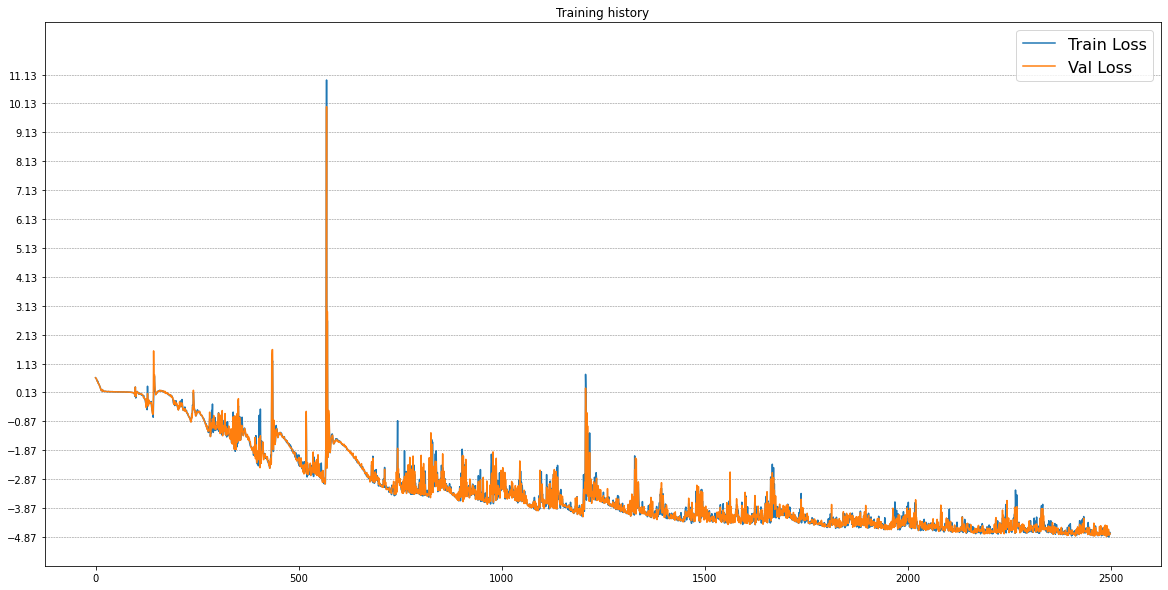

In [7]:
plt.figure(figsize=(20, 10))
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.ylim(min_-1, max_+2)
plt.yticks(ticks)
plt.legend(fontsize=16)
plt.title('Training history');

# Print model summary

In [8]:
pl.model_summary(net)

Model summary
------------------------------------------------------------------------------------------------------------------------
Layer Name                              	Layer Shape                             	# Parameters                            
------------------------------------------------------------------------------------------------------------------------
LSTM_encoder.weight_ih_l0               	(512, 1)                                	512                                     
LSTM_encoder.weight_hh_l0               	(512, 128)                              	65536                                   
LSTM_encoder.bias_ih_l0                 	(512,)                                  	512                                     
LSTM_encoder.bias_hh_l0                 	(512,)                                  	512                                     
LSTM_encoder.weight_ih_l0_reverse       	(512, 1)                                	512                                     
LSTM_e

## Load test data and calculate sim score

  0%|          | 0/9 [00:00<?, ?it/s]

Difference in averages in MC simulation was higher than Tolerance 1.000e-03


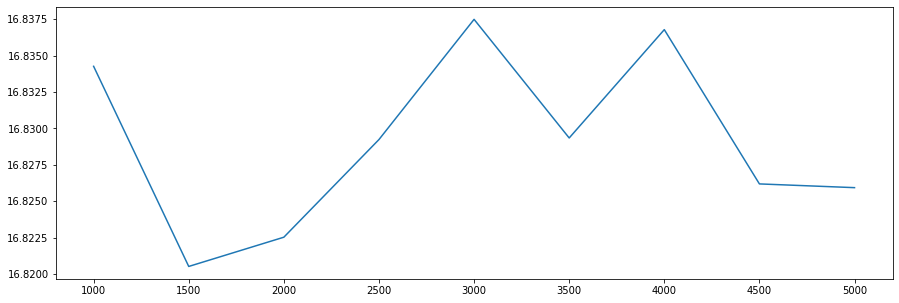

threshold =  16.831147198423743
best L =  5000


In [9]:
# Monte Carlo approach to find the reconstruction threshold

# log-prob threshold
L_values = []
min_probs = []
TOL = 1e-3

prev_avg = np.inf
best_L = 0
patience = 0
PATIENCE_LIMIT = 5
for L in tqdm(np.arange(1000, 5000+500, 500, dtype=np.int64)):
    sim_scores = att.get_sim_scores(net, train_data, L=L, ELBO_loss=criterion)
    min_probs.append(np.min(np.exp(sim_scores)))
    actual_avg = np.mean(np.exp(sim_scores))

    best_L = L
    error = abs(actual_avg - prev_avg)
    L_values.append(L)
    if error < TOL:
        patience += 1
        print(f'Patience {patience}/{PATIENCE_LIMIT}')
        if patience == PATIENCE_LIMIT:

            break

    prev_avg = actual_avg

if error >= TOL:
    print(
        f'Difference in averages in MC simulation was higher than Tolerance {TOL:.3e}')


threshold = np.mean(min_probs[-PATIENCE_LIMIT:])  # use last five values


plt.figure(figsize=(15, 5))

plt.plot(L_values, min_probs)
plt.show()

print('threshold = ', threshold)
print('best L = ', best_L)

# Plot probability threshold


Saving figure:  reconstruction-no-labels-best-L-laplace


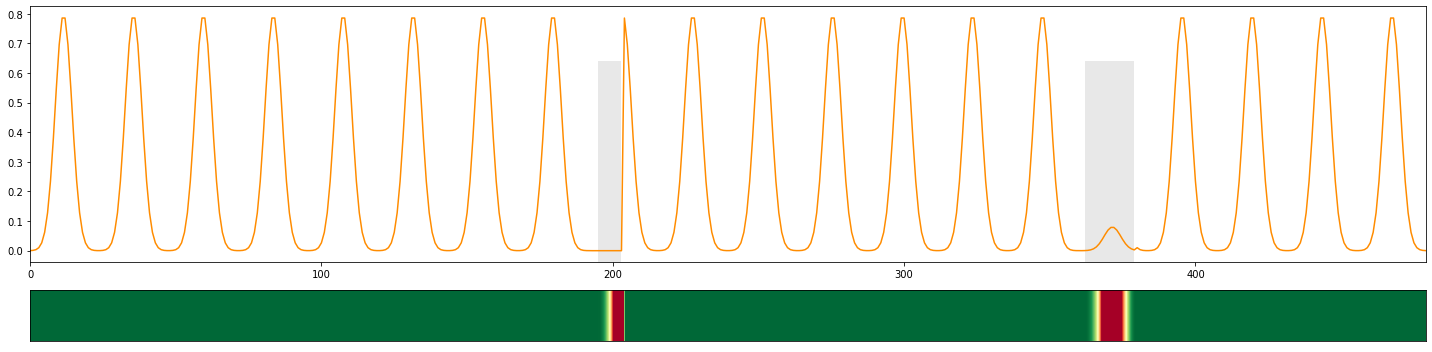

In [10]:
test_data = gd.GetData(T_w, filepath, subset='test')

results_plot(net, test_data, L=best_L, alpha=threshold, ELBO_loss=criterion)
pl.save_fig('reconstruction-no-labels-best-L-laplace')

# Plot attention weights 

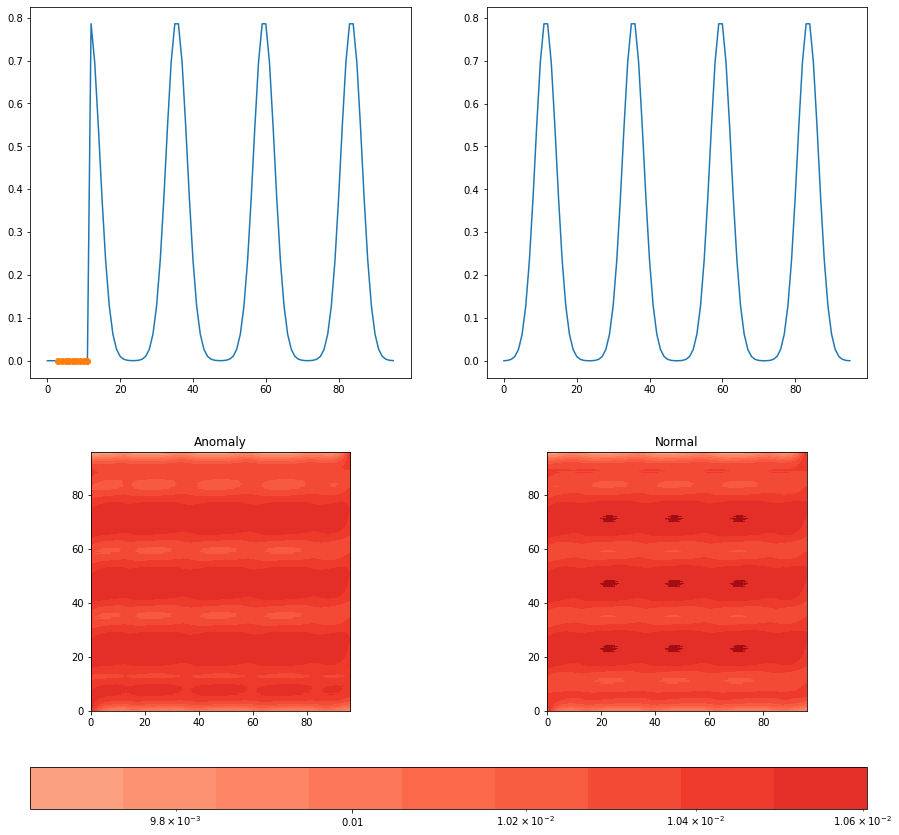

In [11]:
dataset = test_data

batch_size = min((len(dataset), dataset.T_w*100))

loader = DataLoader(dataset, shuffle=False, batch_size=batch_size)

# Re-initialize network
net.batch_size = batch_size
net.init_hidden()
net.eval()
#all_sim_scores = get_sim_scores(net, dataset, L=L, ELBO_loss=ELBO_loss)

attention_anomaly = None
anomaly_regular = None

for x, label in loader:
    # Modify batch size and hidden state
    if x.shape[0] != batch_size:
        net.batch_size = x.shape[0]
        net.init_hidden()

    # Cast to gpu if available
    if torch.cuda.is_available():
        x = x.to(torch.device(0))

    temp_sim = att.tensor2numpy(att.similarity_score(
        net, x, best_L, criterion)).reshape(-1, dataset.T_w)
    anomaly_row, anomaly_col = np.where(temp_sim < np.log(threshold))
    sel_idx_anomaly = np.random.choice(anomaly_row)
    regular_row = np.delete(np.arange(x.shape[0]), anomaly_row)
    sel_idx_regular = np.random.choice(regular_row)

    if (temp_sim < threshold).any():
        X = x[sel_idx_anomaly, :, :].view(1, -1, 1)

        with torch.no_grad():
            net.batch_size = X.shape[0]
            net.init_hidden()
            attention_anomaly = net(X)['A']

    X = x[sel_idx_regular, :, :].view(1, -1, 1)

    with torch.no_grad():
        net.batch_size = X.shape[0]
        net.init_hidden()
        attention_regular = net(X)['A']

    if attention_anomaly is not None and attention_regular is not None:
        break

# assuming one batch only, so no need to concatenate the attention variable
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# even bounds gives a contour-like effect
bounds = np.linspace(-4, 4, 24)
# get one more color than bounds from colormap
colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(bounds)+1))
# create colormap without custom color bounds
cmap = mcolors.ListedColormap(colors[8:-8])

# set upper/lower color
cmap.set_over(colors[-4])
cmap.set_under(colors[4])

# create norm from bounds
anomaly_min = att.tensor2numpy(attention_anomaly).reshape(
    dataset.T_w, dataset.T_w).T.min()
anomaly_max = att.tensor2numpy(attention_anomaly).reshape(
    dataset.T_w, dataset.T_w).T.max()

regular_min = att.tensor2numpy(attention_regular).reshape(
    dataset.T_w, dataset.T_w).T.min()
regular_max = att.tensor2numpy(attention_regular).reshape(
    dataset.T_w, dataset.T_w).T.max()

v_min = anomaly_min if anomaly_min < regular_min else regular_min
v_max = anomaly_max if anomaly_max > regular_max else regular_max


norm = mcolors.LogNorm(vmin=v_min, vmax=v_max)
extent = (0, T_w, 0, T_w)

# print(tensor2numpy(attention).T.shape)
anomaly_data = att.tensor2numpy(
    x[sel_idx_anomaly, :, :].view(1, -1, 1)).reshape(-1)
regular_data = att.tensor2numpy(
    x[sel_idx_regular, :, :].view(1, -1, 1)).reshape(-1)

x = np.arange(len(regular_data))
axs[0][0].plot(x, anomaly_data)
axs[0][0].plot(x[anomaly_col[anomaly_row == sel_idx_anomaly]],
               anomaly_data[anomaly_col[anomaly_row == sel_idx_anomaly]], 'o')
img = axs[1][0].imshow(att.tensor2numpy(attention_anomaly).reshape(dataset.T_w, dataset.T_w).T,
                       norm=norm, cmap=cmap, interpolation='sinc', aspect='equal', origin='lower', extent=extent)
axs[1][0].set_title('Anomaly')
fig.colorbar(img, ax=axs[1], orientation='horizontal', format='$%.2f$')

axs[0][1].plot(x, regular_data)
axs[1][1].imshow(att.tensor2numpy(attention_regular).reshape(dataset.T_w, dataset.T_w).T,
                 norm=norm, cmap=cmap, interpolation='sinc', aspect='equal', origin='lower', extent=extent)
axs[1][1].set_title('Normal')
plt.show()